## Multi-Label Chest X-Ray Pathology Detection of COVID-19 with Transfer Learning
Colm Clancy : 01365631 

### Model Training

In [2]:
'''
from keras.backend import clear_session

def create():
    # do all the model stuff
    # evaluate the model
    clear_session() 
    return
'''

'\nfrom keras.backend import clear_session\n\ndef create():\n    # do all the model stuff\n    # evaluate the model\n    clear_session() \n    return\n'

In [1]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras import layers
#from tensorflow.keras import Model
#from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import Model
#from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.optimizers import SGD
from PIL import ImageFile
import datetime





#from keras.preprocessing import image
#from keras.models import Model
#from keras.layers import Dense, GlobalAveragePooling2D
#from keras import backend as K
#to:

#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#from tensorflow.keras import backend as K

Using TensorFlow backend.


### Load data into google cloud

In [2]:
from google.cloud import storage
client = storage.Client()

In [3]:
bucket = client.get_bucket('dl_cc_bucket')

In [4]:
blob_tf = bucket.get_blob(f"train_val/train_f.csv")
blob_vf = bucket.get_blob(f"train_val/validate_f.csv")

In [5]:
bt_tf = blob_tf.download_as_string()
bt_vf = blob_vf.download_as_string()

In [6]:
from io import StringIO
t = str(bt_tf, "utf-8")
t = StringIO(t)

v = str(bt_vf, "utf-8")
v = StringIO(v)

In [7]:
import pandas as pd
train_df = pd.read_csv(t)
val_df = pd.read_csv(v)
#train_df = pd.read_csv('train_f.csv')
#val_df = pd.read_csv('validate_f.csv')
test_df = pd.read_csv('test_df.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#train_df.columns = train_df.columns.str.strip()
#valid_df.columns = valid_df.columns.str.strip()

In [9]:
'''
bucket_name = 'dl_cc_bucket'
prefix = 'folder/'
dl_dir = 'all_data/'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('/', '_') 
    blob.download_to_filename(dl_dir + filename)  # Download
'''

"\nbucket_name = 'dl_cc_bucket'\nprefix = 'folder/'\ndl_dir = 'all_data/'\n\nstorage_client = storage.Client()\nbucket = storage_client.get_bucket(bucket_name)\nblobs = bucket.list_blobs(prefix=prefix)  # Get list of files\nfor blob in blobs:\n    filename = blob.name.replace('/', '_') \n    blob.download_to_filename(dl_dir + filename)  # Download\n"

In [10]:
'''
#dl_cc_bucket/test
bucket_name = 'dl_cc_bucket'
prefix = 'test/'
dl_dir = 'test/'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('/', '_') 
    blob.download_to_filename(dl_dir + filename)  # Download
'''

"\n#dl_cc_bucket/test\nbucket_name = 'dl_cc_bucket'\nprefix = 'test/'\ndl_dir = 'test/'\n\nstorage_client = storage.Client()\nbucket = storage_client.get_bucket(bucket_name)\nblobs = bucket.list_blobs(prefix=prefix)  # Get list of files\nfor blob in blobs:\n    filename = blob.name.replace('/', '_') \n    blob.download_to_filename(dl_dir + filename)  # Download\n"

In [11]:
for column in train_df.columns:
    if train_df[column].dtype == 'int64':
        train_df[column] = train_df[column].astype('float32')
print(train_df.dtypes)

Unnamed: 0                float32
filename                   object
PatientID                  object
ReportID                   object
age                       float32
                           ...   
vertebral fracture        float32
viral pneumonia           float32
volume loss               float32
radiological finding      float32
differential diagnosis    float32
Length: 205, dtype: object


In [12]:
for column in val_df.columns:
    if val_df[column].dtype == 'int64':
        val_df[column] = val_df[column].astype('float32')
print(val_df.dtypes)

Unnamed: 0                float32
filename                   object
PatientID                  object
ReportID                   object
age                       float32
                           ...   
vertebral fracture        float32
viral pneumonia           float32
volume loss               float32
radiological finding      float32
differential diagnosis    float32
Length: 205, dtype: object


In [13]:
#train_df.head()

### create train/validate/test generators

In [14]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=False, batch_size=32, seed=1, target_w = 224, target_h = 224):
    
    print("getting train generator...") 
    # normalize images
    #image_generator = ImageDataGenerator(
     #   samplewise_center=True,
      #  samplewise_std_normalization= True)
    
    image_generator = ImageDataGenerator( rescale = 1.0/255. )


    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [15]:
#def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
def get_valid_generator(valid_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 224, target_h = 224):


    print("getting train and valid generators...")
    # get generator to sample dataset
    
    image_generator = ImageDataGenerator( rescale = 1.0/255. )

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator


#    return valid_generator, test_generator
    

'\n    test_generator = image_generator.flow_from_dataframe(\n            dataframe=test_df,\n            directory=image_dir,\n            x_col=x_col,\n            y_col=y_cols,\n            class_mode="raw",\n            batch_size=batch_size,\n            shuffle=False,\n            seed=seed,\n            target_size=(target_w,target_h))\n'

In [16]:
#def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
def get_test_generator(test_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 224, target_h = 224):

   
  
    image_generator = ImageDataGenerator( rescale = 1.0/255. )

    # get test generator
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator


In [17]:
#IMAGE_DIR = "/content/drive/My Drive/final_jpg/"
IMAGE_DIR = "/home/jupyter/all_data/"
IMAGE_DIR_test = "/home/jupyter/test/"

#IMAGE_DIR = 'gs://dl_cc_bucket/folder/'
x_col = train_df.filename
y_pr= train_df.drop(['filename', 'PatientID','ReportID','age','sex','Labels','Labels2','Unnamed: 0'], axis=1)
y_cols = y_pr.columns

In [18]:
from pathlib import Path
import pathlib
count = 0
for path in pathlib.Path(IMAGE_DIR).iterdir():
    if path.is_file():
        count += 1

print(count)

40845


In [19]:
#image_generator = ImageDataGenerator( rescale = 1.0/255. )
#valid_generator = image_generator.flow_from_dataframe(
#        dataframe=y_pr,
#        directory=IMAGE_DIR,
#        x_col=valid_df.filename,
#        y_col=y_pr.columns,
#        class_mode="raw",
#        batch_size=1,
#        shuffle=False,
#        seed=1,
#        target_size=(19,19))

#train_df, IMAGE_DIR, "filename", y_cols, batch_size=64


In [20]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "filename", y_cols, batch_size=32)
valid_generator = get_valid_generator(val_df, IMAGE_DIR, "filename", y_cols, batch_size=32)
test_generator = get_test_generator(test_df, IMAGE_DIR_test, "filename", y_cols, batch_size=32)

getting train generator...
Found 30590 validated image filenames.
getting train and valid generators...
Found 10255 validated image filenames.
Found 10158 validated image filenames.


### Address class imbalance 
Coursera:AI for medical diagnosis

In [21]:

def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / labels.shape[0]
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [22]:
freq_pos, freq_neg = compute_class_freqs(y_pr)


In [23]:
pos_weights = tf.cast(freq_neg, tf.float32)
neg_weights = tf.cast(freq_pos, tf.float32)
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [24]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
        return loss
    
    return weighted_loss

#### Visualise class imbalance

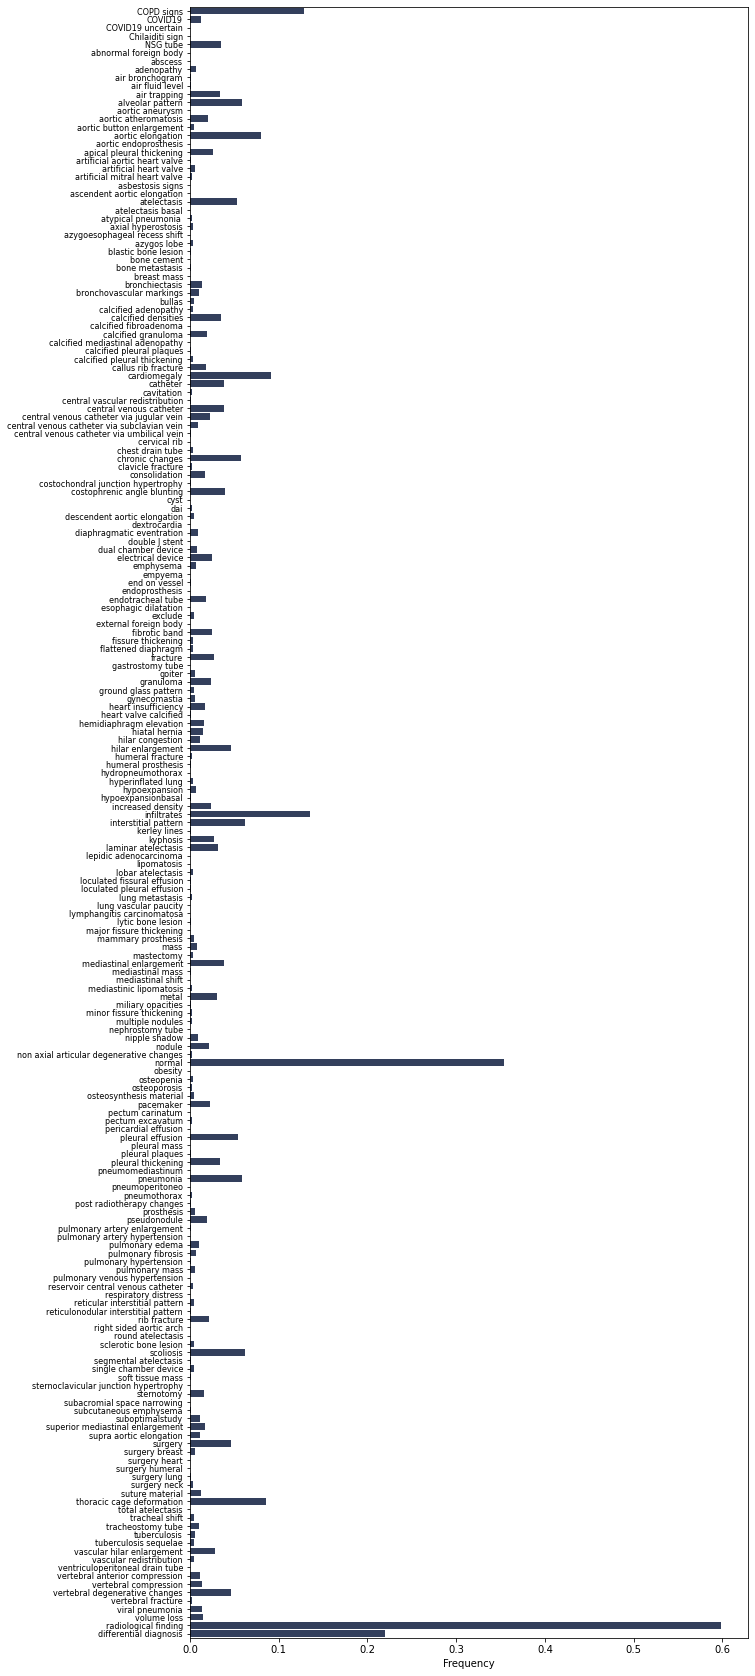

In [125]:
#midnighblue 75% 6C7CA3
#mulberry 75% A7409B


plt.figure(figsize=(10,30))

plt.yticks(size=8)

#plt.barh(y=y_cols, width=np.mean(train_generator.labels, axis=0))
ax =sns.barplot(y=y_cols, x=np.mean(train_generator.labels, axis=0), color='#2c3c63')

#plt.title("Frequency of Each Class")
plt.xlabel('Frequency')
plt.savefig('class_freq2.png', bbox_inches='tight')


#### neg/pos contribution

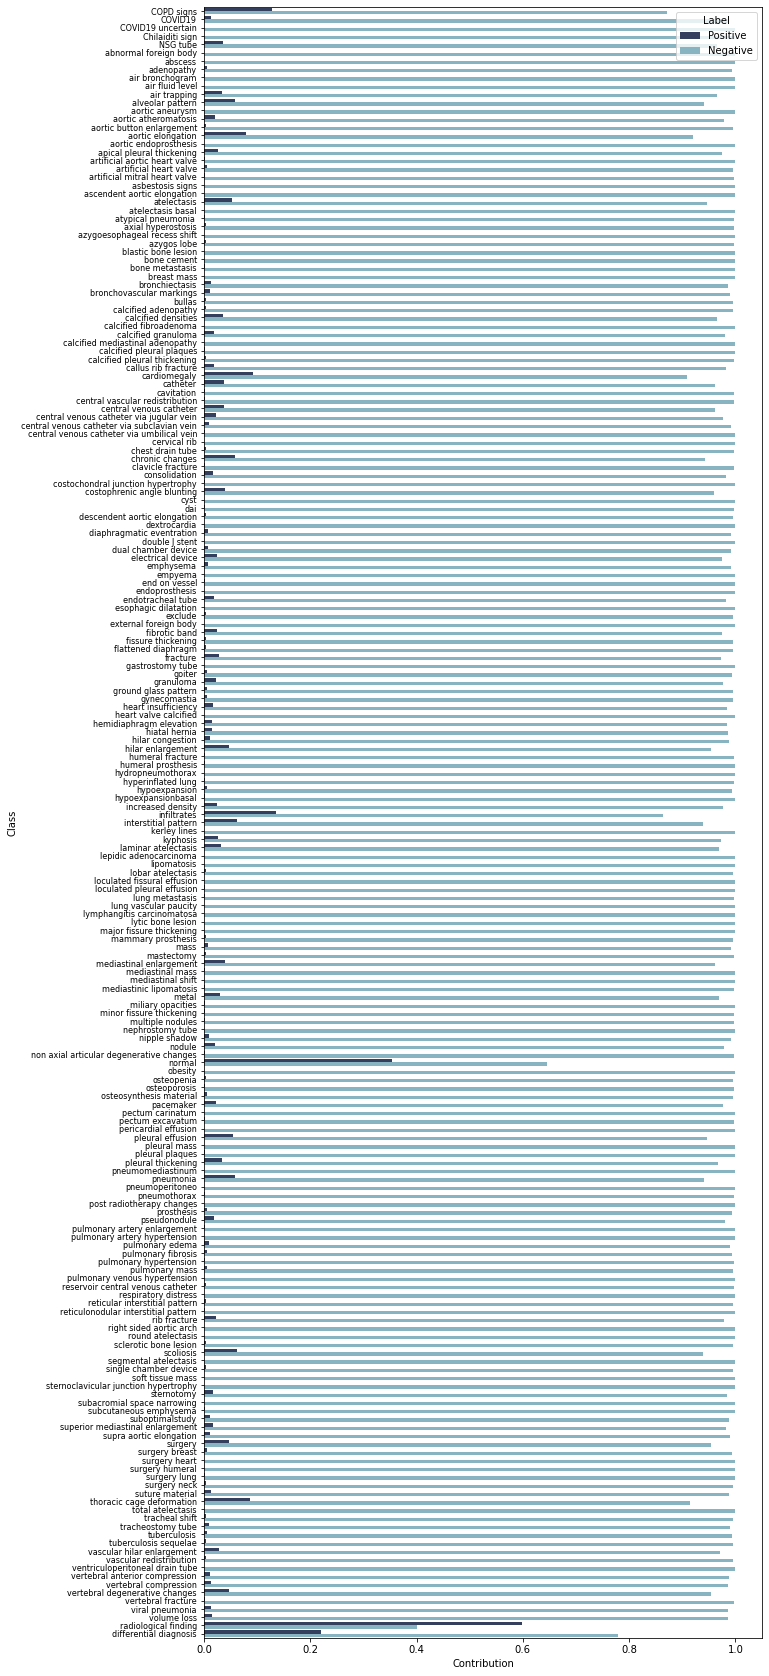

In [122]:

colors =['#2c3c63', '#7ebac9']


customPalette = sns.set_palette(sns.color_palette(colors))

data = pd.DataFrame({"Class": y_cols, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": y_cols[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.figure(figsize=(10,30))
#plt.xticks(rotation=90)
plt.yticks(size=8)
ax =sns.barplot(y="Class", x="Value", hue="Label" ,data=data, palette=customPalette)
ax.set_xlabel('Contribution')
#plt.savefig('./Results.png') # Use fig. here
plt.savefig('class_imbalance.png', bbox_inches='tight')



#### after adjustment

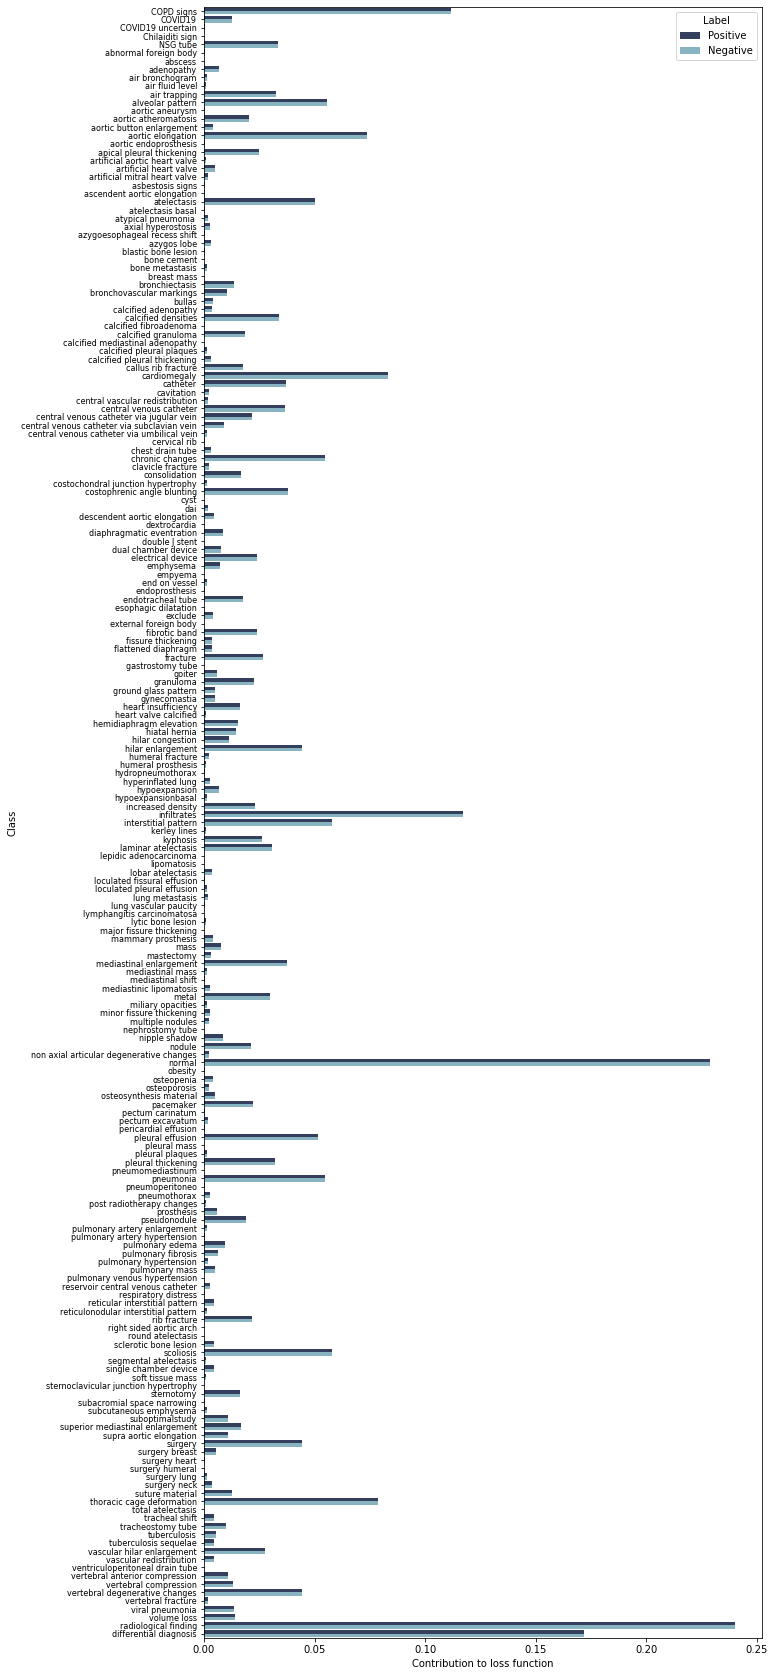

In [123]:
data = pd.DataFrame({"Class": y_cols, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": y_cols[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,30))
#plt.xticks(rotation=90)
plt.yticks(size=8)
ax =sns.barplot(y="Class", x="Value", hue="Label" ,data=data,palette=customPalette)
ax.set_xlabel('Contribution to loss function')
plt.savefig('class_balanced.png', bbox_inches='tight')



# Start model training

### model 1 DenseNet 121

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD

base_model = DenseNet121(input_shape=(224,224,3),weights='imagenet', include_top=False, pooling='avg')

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output

predictions = Dense(197, activation="sigmoid", name='predictions')(x)
epochs=30

opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2/epochs)
model_1 = Model(inputs=base_model.input, outputs=predictions)
model_1.compile(optimizer=opt, loss=get_weighted_loss(pos_weights, neg_weights),metrics = [tf.keras.metrics.AUC()])

In [58]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD

import datetime

#callbacks = [TensorBoard(log_dir=r"logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))]


history_1 = model_1.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 30,
                              verbose=1,
                              steps_per_epoch =30590//32,
                              validation_steps = 10255//256,
#                              callbacks=callbacks,
                              workers=8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 955 steps, validate for 40 steps
Epoch 1/30
955/955 [==============================] - 979s 1s/step - loss: 3.7211 - auc_1: 0.6843 - val_loss: 3.3236 - val_auc_1: 0.7518
Epoch 2/30
955/955 [==============================] - 1044s 1s/step - loss: 3.3594 - auc_1: 0.7457 - val_loss: 3.2106 - val_auc_1: 0.7593
Epoch 3/30
955/955 [==============================] - 1058s 1s/step - loss: 3.2089 - auc_1: 0.7725 - val_loss: 3.2332 - val_auc_1: 0.7853
Epoch 4/30
955/955 [==============================] - 1076s 1s/step - loss: 3.1446 - auc_1: 0.7873 - val_loss: 3.1254 - val_auc_1: 0.7700
Epoch 5/30
955/955 [==============================] - 1097s 1s/step - loss: 3.0839 - auc_1: 0.7976 - val_loss: 3.1490 - val_auc_1: 0.7606
Epoch 6/30
955/955 [==============================] - 1103s 1s/step - loss: 3.0509 - auc_1: 0.8067 - val_loss: 3.1004 - val_auc_1: 0.7681
Epoch 7/30
955/955 [==============================] - 1101s 1s/step - loss: 3.01

In [59]:
pd.DataFrame.from_dict(history_1.history).to_csv('history1.csv',index=False)

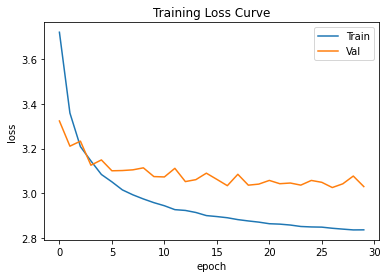

In [60]:
plt.plot(history_1.history['loss'], label='Train')
plt.plot(history_1.history['val_loss'],label='Val')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Training Loss Curve")
plt.savefig('training_loss_1.png', bbox_inches='tight')

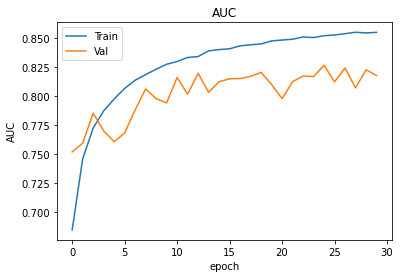

In [61]:
plt.plot(history_1.history['auc_1'],label='Train')
plt.plot(history_1.history['val_auc_1'],label='Val')
plt.ylabel("AUC")
plt.xlabel("epoch")
plt.legend()
plt.title("AUC")
plt.savefig('AUC_curve_1.png', bbox_inches='tight')

In [62]:
model_1_p = model_1.predict(test_generator, steps = len(test_generator))
model_1_p_df = pd.DataFrame(model_1_p)
model_1_p_df.to_csv('model1.csv',index=False)

### model 2 DenseNet121+

In [28]:
base_model = DenseNet121(weights='imagenet', include_top=False)

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  
x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.2)(x)  

x = GlobalAveragePooling2D()(x)

predictions = Dense(197, activation="sigmoid", name='predictions')(x)

epochs = 30

opt = SGD(lr=1e-02, momentum=0.9, decay=1e-2/epochs)
#opt = SGD(lr=1e-02, momentum=0.9)
model_2 = Model(inputs=base_model.input, outputs=predictions)
model_2.compile(optimizer=opt, loss=get_weighted_loss(pos_weights, neg_weights),metrics = ['accuracy',tf.keras.metrics.AUC(multi_label=False)])



In [26]:
#callbacks = [TensorBoard(log_dir=r"logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))]

history_2 = model_2.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              epochs = 30,
                              verbose=1,
                              steps_per_epoch =30590//32,
                              validation_steps = 10255//512,
#                              callbacks=callbacks,
                              workers=8)
                  


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
955/955 [==============================] - 357s 373ms/step - loss: 3.4020 - accuracy: 0.1768 - auc: 0.7212 - val_loss: 3.1977 - val_accuracy: 0.2844 - val_auc: 0.7289
Epoch 2/30
955/955 [==============================] - 598s 627ms/step - loss: 3.1549 - accuracy: 0.2438 - auc: 0.7721 - val_loss: 3.1045 - val_accuracy: 0.2797 - val_auc: 0.7707
Epoch 3/30
955/955 [==============================] - 956s 1s/step - loss: 3.0745 - accuracy: 0.2532 - auc: 0.7859 - val_loss: 3.0413 - val_accuracy: 0.2750 - val_auc: 0.7961
Epoch 4/30
955/955 [==============================] - 842s 881ms/step - loss: 3.0215 - accuracy: 0.2586 - auc: 0.7981 - val_loss: 3.0214 - val_accuracy: 0.2094 - val_auc: 0.8012
Epoch 5/30
955/955 [==============================] - 830s 869ms/step - loss: 2.9740 - accuracy: 0.2519 - auc: 0.8065 - val_loss: 3.0148 - val_accuracy: 0.2047 - val_auc: 0.7906
Epoch 6/30
955/955 [=================

In [1]:
#with open('/trainHistoryDict_2', 'wb') as file_pi:
#    pickle.dump(history_2.history, file_pi)

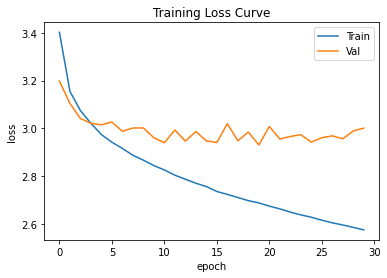

In [ ]:
plt.plot(history_2.history['loss'], label='Train')
plt.plot(history_2.history['val_loss'],label='Val')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Training Loss Curve")
plt.savefig('training_loss_2.png', bbox_inches='tight')

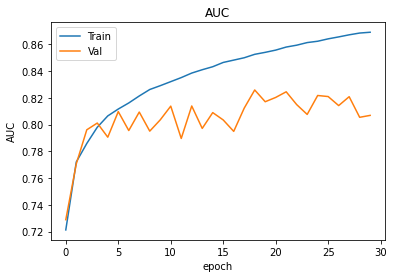

In [29]:
plt.plot(history_2.history['auc'],label='Train')
plt.plot(history_2.history['val_auc'],label='Val')
plt.ylabel("AUC")
plt.xlabel("epoch")
plt.legend()
plt.title("AUC")
plt.savefig('AUC_curve_2.png', bbox_inches='tight')

In [30]:
pd.DataFrame.from_dict(history_2.history).to_csv('history2.csv',index=False)

In [31]:
model_2_p = model_2.predict(test_generator, steps = len(test_generator))
model_2_p_df = pd.DataFrame(model_2_p)
model_2_p_df.to_csv('model2.csv',index=False)